In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
prng = np.random.RandomState(10)

In [4]:
from cgpm2.transition_crosscat import GibbsCrossCat

In [5]:
from cgpm2.flexible_rowmix import FlexibleRowMixture
from cgpm2.product import Product
from cgpm2.crp import CRP
from cgpm2.normal import Normal
from cgpm2.categorical import Categorical

### Basic univariate 3 component mixture 

In [6]:
data0 = prng.normal(loc=0, scale=2, size=20)
data1 = prng.normal(loc=30, scale=1, size=20)
data2 = prng.normal(loc=-30, scale=1, size=20)

In [7]:
data = np.concatenate((data0, data1, data2))

In [8]:
view = FlexibleRowMixture(
    cgpm_row_divide=CRP([-1], [], rng=prng),
    cgpm_components_base=Product(cgpms=[Normal([0], [], rng=prng)]),
    rng=prng)
crosscat = Product(cgpms=[view])

In [9]:
for rowid, value in enumerate(data):
    crosscat.incorporate(rowid, {0: value})

In [10]:
inference = GibbsCrossCat(crosscat, prng)
inference.transition_structure_cpp(N=1000)

Completed: 1000 iterations in 7.141326 seconds.


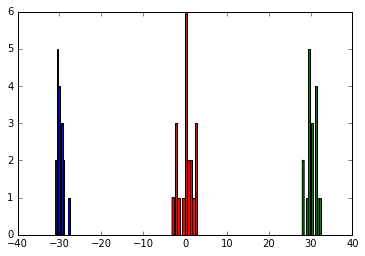

In [11]:
assignments = inference.crosscat.cgpms[0].cgpm_row_divide.data
counts = inference.crosscat.cgpms[0].cgpm_row_divide.counts
fig, ax = plt.subplots()
for cluster in counts:
    rowids = [rowid for rowid, z in assignments.iteritems() if z == cluster]
    ax.hist(data[rowids])

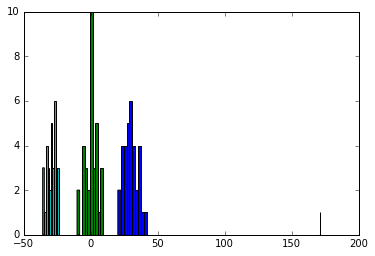

In [12]:
crp_output = inference.crosscat.cgpms[0].cgpm_row_divide.outputs[0]
samples = inference.crosscat.simulate(None, [crp_output,0], N=100)
fig, ax = plt.subplots()
zs = set([s[crp_output] for s in samples])
for z in zs:
    xs = [s[0] for s in samples if s[crp_output] == z]
    ax.hist(xs)

In [13]:
inference.transition(N=100, kernels=['hypers_distributions','hypers_row_divide'])

Completed: 100 iterations in 1.554741 seconds.


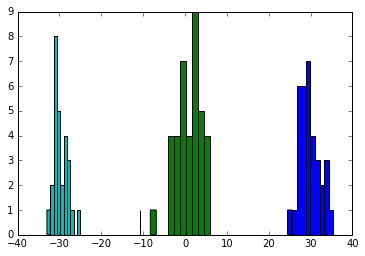

In [14]:
crp_output = inference.crosscat.cgpms[0].cgpm_row_divide.outputs[0]
samples = inference.crosscat.simulate(None, [crp_output,0], N=100)
fig, ax = plt.subplots()
zs = set([s[crp_output] for s in samples])
for z in zs:
    xs = [s[0] for s in samples if s[crp_output] == z]
    ax.hist(xs)

### Basic bivariate 2 component mixture with DPMM 

In [15]:
view = FlexibleRowMixture(
    cgpm_row_divide=CRP([-1], [], rng=prng),
    cgpm_components_base=Product([
        Normal([0], [], rng=prng),
        Normal([1], [], rng=prng),
    ]),
    rng=prng)
crosscat = Product(cgpms=[view])

In [16]:
df = pd.read_csv('resources/two_clusters.csv', index_col=False)

In [17]:
df.loc[0,'x'] = df.loc[50,'y'] = np.nan
df.loc[10,'x'] = df.loc[30,'y'] = np.nan
df.loc[33,'x'] = df.loc[33,'y'] = np.nan

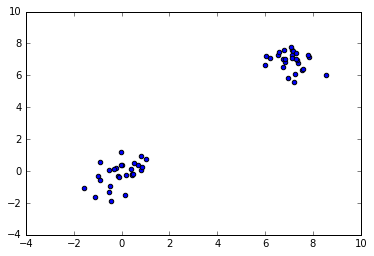

In [18]:
fig, ax = plt.subplots()
ax.scatter(df.x, df.y)

In [19]:
for rowid, row in df.iterrows():
    crosscat.incorporate(rowid, {0: row.x, 1: row.y})

In [20]:
inference = GibbsCrossCat(crosscat, prng)
inference.transition_row_assignments_cpp(N=1000)

Completed: 1000 iterations in 6.321995 seconds.


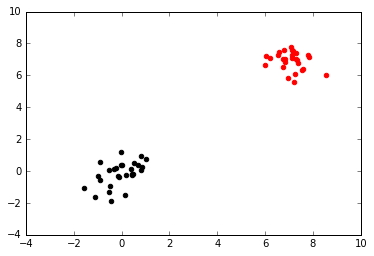

In [21]:
assignments = inference.crosscat.cgpms[0].cgpm_row_divide.data
counts = inference.crosscat.cgpms[0].cgpm_row_divide.counts
fig, ax = plt.subplots()
for cluster,color in zip(counts, ['r','k','g','y','b']):
    rowids = [rowid for rowid, z in assignments.iteritems() if z == cluster]
    ax.scatter(df.loc[rowids].x, df.loc[rowids].y, color=color)

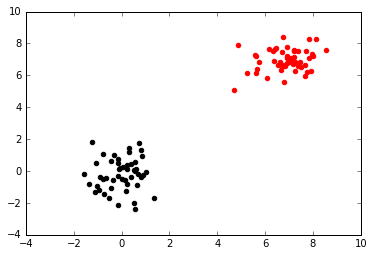

In [22]:
crp_output = inference.crosscat.cgpms[0].cgpm_row_divide.outputs[0]
samples = inference.crosscat.simulate(None, [crp_output,0, 1], N=100)
fig, ax = plt.subplots()
zs = set([s[crp_output] for s in samples])
for z, c in zip(zs, ['r','k','b','g']):
    xs = [s[0] for s in samples if s[crp_output] == z]
    ys = [s[1] for s in samples if s[crp_output] == z]
    ax.scatter(xs,ys, color=c)

In [23]:
inference.transition(N=100, kernels=['hypers_distributions','hypers_row_divide'])

Completed: 100 iterations in 1.763184 seconds.


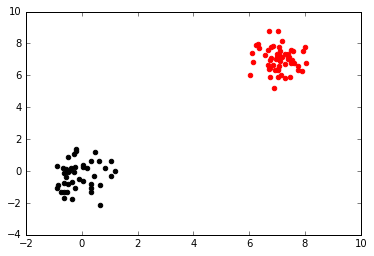

In [24]:
crp_output = inference.crosscat.cgpms[0].cgpm_row_divide.outputs[0]
samples = inference.crosscat.simulate(None, [crp_output,0, 1], N=100)
fig, ax = plt.subplots()
zs = set([s[crp_output] for s in samples])
for z, c in zip(zs, ['r','k','b','g']):
    xs = [s[0] for s in samples if s[crp_output] == z]
    ys = [s[1] for s in samples if s[crp_output] == z]
    ax.scatter(xs,ys, color=c)

### Basic bivariate 2 component mixture with CrossCat and category inference

In [25]:
crosscat = Product([
    FlexibleRowMixture(
        cgpm_row_divide=CRP([-1], [], rng=prng),
        cgpm_components_base=Product([
            Normal([10], [], rng=prng),
        ]),
        rng=prng),
    FlexibleRowMixture(
        cgpm_row_divide=CRP([-2], [], rng=prng),
        cgpm_components_base=Product([
            Normal([11], [], rng=prng),
        ]),
        rng=prng),
])

In [26]:
for rowid, row in df.iterrows():
    crosscat.incorporate(rowid, {10: row.x, 11: row.y})

In [27]:
inference = GibbsCrossCat(crosscat, prng)
inference.transition_structure_cpp(N=2000)

Completed: 2000 iterations in 16.530178 seconds.


In [28]:
inference.transition(N=300, kernels=['hypers_distributions','hypers_row_divide'])

Completed: 300 iterations in 4.800651 seconds.


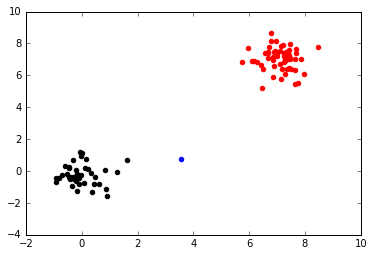

In [29]:
crp_output = inference.crosscat.cgpms[0].cgpm_row_divide.outputs[0]
samples = inference.crosscat.simulate(None, [crp_output,10,11], N=100)
fig, ax = plt.subplots()
zs = set([s[crp_output] for s in samples])
for z, c in zip(zs, ['r','k','b','g']):
    xs = [s[10] for s in samples if s[crp_output] == z]
    ys = [s[11] for s in samples if s[crp_output] == z]
    ax.scatter(xs,ys, color=c)

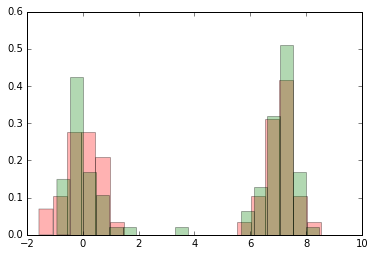

In [30]:
fig, ax = plt.subplots()
ax.hist(df['x'].dropna(), bins=20, normed=True, alpha=0.3, color='r');
ax.hist([s[10] for s in samples], bins=20, normed=True, alpha=0.3, color='g');

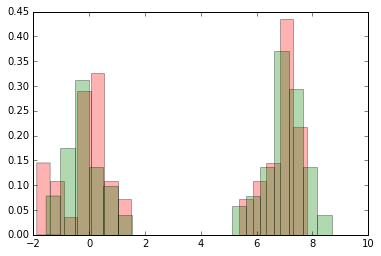

In [31]:
fig, ax = plt.subplots()
ax.hist(df['y'].dropna(), bins=20, normed=True, alpha=0.3, color='r');
ax.hist([s[11] for s in samples], bins=20, normed=True, alpha=0.3, color='g');

### Basic bivariate 2 component mixture with CrossCat and category inference and nominal variable

In [32]:
df['z'] = 0
df.loc[:15,'z'] = 0
df.loc[15:30,'z'] = 1
df.loc[30:45,'z'] = 2
df.loc[45:60,'z'] = 3

In [33]:
crosscat = Product([
    FlexibleRowMixture(
        cgpm_row_divide=CRP([-1], [], rng=prng),
        cgpm_components_base=Product([
            Normal([10], [], rng=prng),
        ]),
        rng=prng),
    FlexibleRowMixture(
        cgpm_row_divide=CRP([-2], [], rng=prng),
        cgpm_components_base=Product([
            Normal([11], [], rng=prng),
            Categorical([50], [], distargs={'k':4}, rng=prng),
        ]),
        rng=prng),
])

In [34]:
for rowid, row in df.iterrows():
    crosscat.incorporate(rowid, {10: row.x, 11: row.y, 50:row.z})

In [35]:
inference = GibbsCrossCat(crosscat, prng)
inference.transition_structure_cpp(N=2000)

Completed: 2000 iterations in 17.973100 seconds.


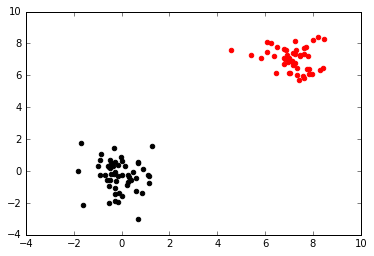

In [36]:
crp_output = inference.crosscat.cgpms[0].cgpm_row_divide.outputs[0]
samples = inference.crosscat.simulate(None, [crp_output,10,11], N=100)
fig, ax = plt.subplots()
zs = set([s[crp_output] for s in samples])
for z, c in zip(zs, ['r','k','b','g']):
    xs = [s[10] for s in samples if s[crp_output] == z]
    ys = [s[11] for s in samples if s[crp_output] == z]
    ax.scatter(xs,ys, color=c)

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


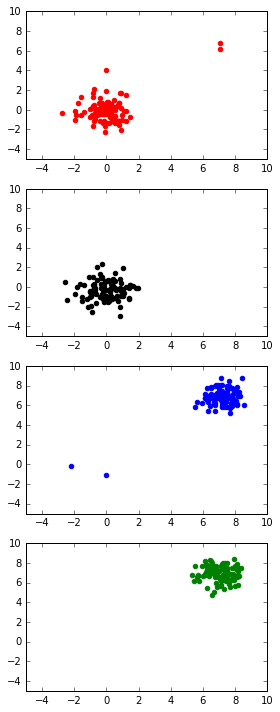

In [37]:
fig, axes = plt.subplots(nrows=4)
for ax, z, c in zip(axes, [0,1,2,3], ['r','k','b','g']):
    samples = inference.crosscat.simulate(None, [10,11], {50:z}, N=100)
    xs = [s[10] for s in samples]
    ys = [s[11] for s in samples]
    ax.scatter(xs,ys, color=c)
    ax.set_xlim([-5,10])
    ax.set_ylim([-5,10])
fig.set_size_inches(4,10)
fig.set_tight_layout(True)